In [6]:
from transformers import get_linear_schedule_with_warmup, AdamW, XLMRobertaTokenizer
from sklearn.utils.class_weight import compute_class_weight
import torch.nn as nn
import numpy as np
import torch
import pandas as pd
from sklearn.model_selection import train_test_split
from sklearn.metrics import f1_score, precision_score, recall_score, confusion_matrix
from torch.utils.data import DataLoader, Dataset
from model_3 import SemanticClassifier
import copy

min_delta = 0.001
patience = 3
best_loss = float('inf')
counter = 0
best_model_wts = None

class CustomDataset(Dataset):
    def __init__(self, texts, labels, tokenizer, max_length=256, device="cuda" if torch.cuda.is_available() else "cpu"):
        self.texts = texts
        self.labels = labels
        self.tokenizer = tokenizer
        self.max_length = max_length
        self.device = device

    def __len__(self):
        return len(self.texts)
    
    def __getitem__(self, idx):
        text = self.texts[idx]
        label = self.labels[idx]

        encoding = self.tokenizer(
            text,
            padding='max_length',
            truncation=True,
            max_length=self.max_length,
            return_tensors="pt"
        )

        return {
            'input_ids': encoding['input_ids'].squeeze(0).to(self.device),
            'attention_mask': encoding['attention_mask'].squeeze(0).to(self.device),
            'labels': torch.tensor(label, dtype=torch.long).to(self.device)
        }

df = pd.read_csv("data/processed_data_2.csv")

tokenizer = XLMRobertaTokenizer.from_pretrained('xlm-roberta-base')

train_texts, val_texts, train_labels, val_labels = train_test_split(
    df["comment"].tolist(), df["rating_star"].tolist(), test_size=0.2, random_state=42
)

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

train_dataset = CustomDataset(train_texts, train_labels, tokenizer, device=device)
val_dataset = CustomDataset(val_texts, val_labels, tokenizer, device=device)

train_dataloader = DataLoader(train_dataset, batch_size=32, shuffle=True)
val_dataloader = DataLoader(val_dataset, batch_size=32, shuffle=False)

class_weights = compute_class_weight(class_weight="balanced", classes=np.unique(train_labels), y=train_labels)
class_weights = torch.tensor(class_weights, dtype=torch.float).to(device)

model = SemanticClassifier()
model.to(device)

best_model_wts = copy.deepcopy(model.state_dict())

stage1_num_epochs = 3
optimizer = AdamW(model.parameters(), lr=2e-5)
loss_fn = nn.CrossEntropyLoss(weight=class_weights)
total_steps = len(train_dataloader) * stage1_num_epochs
scheduler = get_linear_schedule_with_warmup(optimizer, num_warmup_steps=0, num_training_steps=total_steps)

for param in model.bert.encoder.layer.parameters():
    param.requires_grad = False

for epoch in range(stage1_num_epochs):
    model.train()
    epoch_loss = 0.0

    for batch in train_dataloader:
        batch_ids, batch_mask, batch_y = batch["input_ids"], batch["attention_mask"], batch["labels"]
        batch_ids, batch_mask, batch_y = batch_ids.to(device), batch_mask.to(device), batch_y.to(device)

        outputs = model(batch_ids, attention_mask=batch_mask)  
        loss = loss_fn(outputs, batch_y)

        optimizer.zero_grad()
        loss.backward()
        optimizer.step()
        scheduler.step()

        epoch_loss += loss.item()

    avg_loss = epoch_loss / len(train_dataloader)
    
    model.eval()
    val_loss = 0.0
    with torch.no_grad():
        for batch in val_dataloader:
            batch_ids, batch_mask, batch_y = batch["input_ids"], batch["attention_mask"], batch["labels"]
            outputs = model(batch_ids, attention_mask=batch_mask)
            loss = loss_fn(outputs, batch_y)
            val_loss += loss.item()
    
    avg_val_loss = val_loss / len(val_dataloader)
    print(f"Stage 1, Epoch [{epoch+1}/{stage1_num_epochs}], Train Loss: {avg_loss:.4f}, Val Loss: {avg_val_loss:.4f}")
    
    if avg_val_loss < best_loss - min_delta:
        best_loss = avg_val_loss
        best_model_wts = copy.deepcopy(model.state_dict())
        counter = 0
    else:
        counter += 1
        if counter >= patience:
            print(f"Early stopping at epoch {epoch+1}")
            break

model.load_state_dict(best_model_wts)

for param in model.bert.encoder.layer[:-8].parameters():
    param.requires_grad = True

stage2_num_epochs = 10
optimizer = AdamW(model.parameters(), lr=2e-5)  
total_steps = len(train_dataloader) * stage2_num_epochs
scheduler = get_linear_schedule_with_warmup(optimizer, num_warmup_steps=0, num_training_steps=total_steps)

best_loss = float('inf')
counter = 0
best_model_wts = copy.deepcopy(model.state_dict())

for epoch in range(stage2_num_epochs):
    model.train()
    epoch_loss = 0.0

    for batch in train_dataloader:
        batch_ids, batch_mask, batch_y = batch["input_ids"], batch["attention_mask"], batch["labels"]
        batch_ids, batch_mask, batch_y = batch_ids.to(device), batch_mask.to(device), batch_y.to(device)

        outputs = model(batch_ids, attention_mask=batch_mask)  
        loss = loss_fn(outputs, batch_y)

        optimizer.zero_grad()
        loss.backward()
        optimizer.step()
        scheduler.step()

        epoch_loss += loss.item()

    avg_loss = epoch_loss / len(train_dataloader)
    
    model.eval()
    val_loss = 0.0
    with torch.no_grad():
        for batch in val_dataloader:
            batch_ids, batch_mask, batch_y = batch["input_ids"], batch["attention_mask"], batch["labels"]
            outputs = model(batch_ids, attention_mask=batch_mask)
            loss = loss_fn(outputs, batch_y)
            val_loss += loss.item()
    
    avg_val_loss = val_loss / len(val_dataloader)
    print(f"Stage 2, Epoch [{epoch+1}/{stage2_num_epochs}], Train Loss: {avg_loss:.4f}, Val Loss: {avg_val_loss:.4f}")
    
    if avg_val_loss < best_loss - min_delta:
        best_loss = avg_val_loss
        best_model_wts = copy.deepcopy(model.state_dict())
        counter = 0
    else:
        counter += 1
        if counter >= patience:
            print(f"Early stopping at epoch {epoch+1}")
            break

model.load_state_dict(best_model_wts)
print("Training Done!")

c:\Users\USER\AppData\Local\Programs\Python\Python312\Lib\site-packages\transformers\optimization.py:640: FutureWarning: This implementation of AdamW is deprecated and will be removed in a future version. Use the PyTorch implementation torch.optim.AdamW instead, or set `no_deprecation_warning=True` to disable this warning
  warnings.warn(


Stage 1, Epoch [1/3], Train Loss: 1.1307, Val Loss: 1.0754
Stage 1, Epoch [2/3], Train Loss: 1.0725, Val Loss: 1.0675
Stage 1, Epoch [3/3], Train Loss: 1.0718, Val Loss: 1.0639
Stage 2, Epoch [1/10], Train Loss: 0.9398, Val Loss: 0.8492
Stage 2, Epoch [2/10], Train Loss: 0.8095, Val Loss: 0.7618
Stage 2, Epoch [3/10], Train Loss: 0.7516, Val Loss: 0.7441
Stage 2, Epoch [4/10], Train Loss: 0.7052, Val Loss: 0.7121
Stage 2, Epoch [5/10], Train Loss: 0.6689, Val Loss: 0.7088
Stage 2, Epoch [6/10], Train Loss: 0.6225, Val Loss: 0.6792
Stage 2, Epoch [7/10], Train Loss: 0.6087, Val Loss: 0.6957
Stage 2, Epoch [8/10], Train Loss: 0.6004, Val Loss: 0.7057
Stage 2, Epoch [9/10], Train Loss: 0.5694, Val Loss: 0.7181
Early stopping at epoch 9
Training Done!


In [7]:
model.eval()
val_loss = 0.0
correct = 0
total = 0
all_preds = []
all_labels = []

with torch.no_grad():
    for batch in val_dataloader:
        batch_ids, batch_mask, batch_y = batch["input_ids"], batch["attention_mask"], batch["labels"]

        outputs = model(batch_ids, attention_mask=batch_mask)
        loss = loss_fn(outputs, batch_y)
        val_loss += loss.item()

        preds = torch.argmax(outputs, dim=1)
        correct += (preds == batch_y).sum().item()
        total += batch_y.size(0)

        all_preds.extend(preds.cpu().numpy())
        all_labels.extend(batch_y.cpu().numpy())

    avg_val_loss = val_loss / len(val_dataloader)
    accuracy = correct / total 
    f1 = f1_score(all_labels, all_preds, average="weighted")
    precision = precision_score(all_labels, all_preds, average="weighted")
    recall = recall_score(all_labels, all_preds, average="weighted")
    conf_matrix = confusion_matrix(all_labels, all_preds)

    print(f"Final Train Loss: {avg_loss:.4f}")
    print(f"Final Val Loss: {avg_val_loss:.4f}")
    print(f"Final Accuracy: {accuracy:.4f}")
    print(f"Final F1 Score: {f1:.4f}")
    print(f"Final Precision: {precision:.4f}")
    print(f"Final Recall: {recall:.4f}")
    print("\nConfusion Matrix:")
    print(conf_matrix)

Final Train Loss: 0.5694
Final Val Loss: 0.6792
Final Accuracy: 0.7192
Final F1 Score: 0.7300
Final Precision: 0.7501
Final Recall: 0.7192

Confusion Matrix:
[[465 174  22]
 [ 84 253  78]
 [ 36 141 652]]


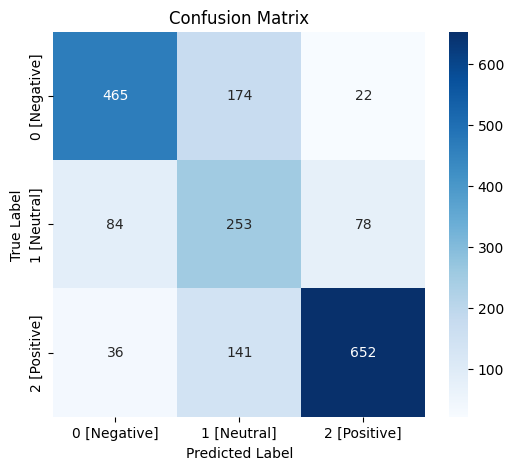

In [8]:
import matplotlib.pyplot as plt
import seaborn as sns

class_labels = ["0 [Negative]", "1 [Neutral]", "2 [Positive]"]

plt.figure(figsize=(6, 5))
sns.heatmap(conf_matrix, annot=True, fmt="d", cmap="Blues", xticklabels=class_labels, yticklabels=class_labels)

plt.xlabel("Predicted Label")
plt.ylabel("True Label")
plt.title("Confusion Matrix")
plt.show()

In [10]:
torch.save(model.state_dict(), "data/semantic_classifier_3_dict.pth")